# United States presidential elections (Nov. 2024)

## Get the data

### Get the hexagonal tiling

Use [`geopandas.read_file`](https://geopandas.org/en/stable/docs/reference/api/geopandas.read_file.html) to retrieve the hexagonal tiling of the United States. Compute and store the centroid of each hexagon, which will serve as the anchor point for the state abbreviation. 

In [79]:
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import pandas as pd
from mpl_ornaments.titles import set_title_and_subtitle

#Read the hexagons
df_hexgrid = gpd.read_file('https://raw.githubusercontent.com/bianconif/graphic_communication_notebooks/refs/heads/master/data/geo/us-hexgrid-stanke/HexStatesPadded/HexStatesPadded.shp')

#Compute and store the centroids
df_hexgrid['centroids'] = df_hexgrid['geometry'].centroid

print(df_hexgrid.head())

HTTPError: HTTP Error 404: Not Found

Observe that the hexagons and centroids are respectively stored as _polygons_ (`POLYGON`) and _point_ (`POINT`) GIS primitives (see also our [article on choroplet maps](https://medium.com/@bianco_29735/graphic-communication-with-python-5-choroplet-map-56b3228e0a60) for further details on this).   

### Get the election results

Get the election results by state. Keep only the `STATE`, `HARRIS`, `TRUMP`, `ELECTORAL VOTES` and `TOTAL VOTES` columns. Add three columns respectively showing the winner for each state (`WINNER`), the number of votes received by the winner (`VOTES_WINNER`) and the percentage of votes received by the winner (`PERC_WINNER`).

In [70]:
#Get the election results
df_votes = pd.read_csv('../../data/usgov/2024presgeresults.csv', index_col=None, comment='#')
df_votes = df_votes[['STATE', 'HARRIS', 'TRUMP', 'ELECTORAL VOTES', 'TOTAL VOTES']]

#Store winner, number of votes of the winner and percentage of votes of the winner 
df_votes['WINNER'] = np.where(df_votes['HARRIS'] > df_votes['TRUMP'], 'HARRIS', 'TRUMP')
df_votes['VOTES_WINNER'] = np.where(df_votes['WINNER'] == 'HARRIS', df_votes['HARRIS'], df_votes['TRUMP'])
df_votes['PERC_WINNER'] = 100*df_votes['VOTES_WINNER']/df_votes['TOTAL VOTES']

print(df_votes.head())

  STATE   HARRIS    TRUMP  ELECTORAL VOTES  TOTAL VOTES  WINNER  VOTES_WINNER  \
0    AL   772412  1462616                9      2265090   TRUMP       1462616   
1    AK   140026   184458                3       338177   TRUMP        184458   
2    AZ  1582860  1770242               11      3390161   TRUMP       1770242   
3    AR   396905   759241                6      1182676   TRUMP        759241   
4    CA  9276179  6081697               54     15865475  HARRIS       9276179   

   PERC_WINNER  
0    64.572092  
1    54.544809  
2    52.217048  
3    64.196872  
4    58.467704  


Merge the geographical data (hexgrid) with the election results.

In [71]:
df_merged = pd.merge(left=df_hexgrid, right=df_votes, left_on='State_Abbr', right_on='STATE')
print(df_merged.head())

        State State_Abbr                                           geometry  \
0     Alabama         AL  POLYGON ((14.06 0.133, 14.06 1.156, 14.99 1.71...   
1      Alaska         AK  POLYGON ((0.06 10.333, 0.06 11.356, 0.99 11.91...   
2     Arizona         AZ  POLYGON ((5.06 1.833, 5.06 2.856, 5.99 3.414, ...   
3    Arkansas         AR  POLYGON ((11.06 1.833, 11.06 2.856, 11.99 3.41...   
4  California         CA  POLYGON ((3.06 1.833, 3.06 2.856, 3.99 3.414, ...   

              centroids STATE   HARRIS    TRUMP  ELECTORAL VOTES  TOTAL VOTES  \
0  POINT (14.99 0.6445)    AL   772412  1462616                9      2265090   
1  POINT (0.99 10.8445)    AK   140026   184458                3       338177   
2   POINT (5.99 2.3445)    AZ  1582860  1770242               11      3390161   
3  POINT (11.99 2.3445)    AR   396905   759241                6      1182676   
4   POINT (3.99 2.3445)    CA  9276179  6081697               54     15865475   

   WINNER  VOTES_WINNER  PERC_WINNER  

## Create the chart

### Define the layout

Let's organise the chart in three parts: one sub-plot for the main chart (`ax1`) and two for the legends, respectively one legend for Harris (`ax2`) and one for Trump (`ax3`).

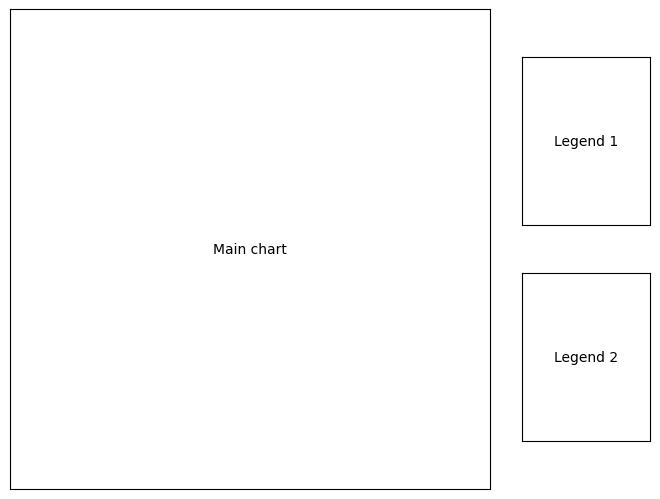

In [72]:
#Create and empty figure
fig = plt.figure()

#Add the sub-plots
ax0 = fig.add_axes(rect=[0.0, 0.0, 0.75, 1.0])
ax1 = fig.add_axes(rect=[0.8, 0.55, 0.2, 0.35])
ax2 = fig.add_axes(rect=[0.8, 0.10, 0.2, 0.35])

ax0.text(s=f'Main chart', x=0.5, y=0.5, ha='center', va='center')
ax1.text(s=f'Legend 1', x=0.5, y=0.5, ha='center', va='center')
ax2.text(s=f'Legend 2', x=0.5, y=0.5, ha='center', va='center')

for idx, ax in enumerate([ax0, ax1, ax2]):
    ax.set_xticks([])
    ax.set_yticks([])

### Plot the hexagon grid

Generate a plot of the hexagon grid using [`geopandas.GeoDataFrame.plot`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html). Add state abbreviations at the centroids through [`matplotlib.axes.Axes.text`](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.text.html). 

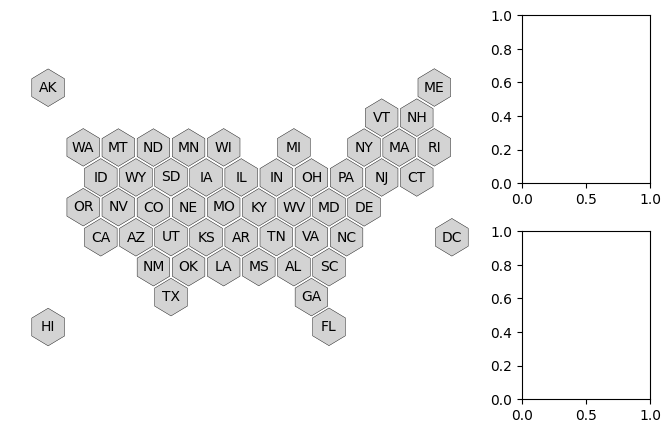

In [73]:
for idx, ax in enumerate([ax0, ax1, ax2]):
    ax.clear()

#Plot the hexagons
df_merged.plot(ax=ax0, color='lightgrey', edgecolor='black', linewidth=0.3)

#Display state abbreviations
for _, row in df_merged.iterrows():
    ax0.text(x=row['centroids'].x, y=row['centroids'].y, s=row['State_Abbr'], ha='center', va='center')

#Suppress all axis decorations
ax0.set_axis_off()

display(fig)

### Generate the choroplet map

Choose a sequential colourmap in the shades of blue for Harris (Democrat) and one in the shades of red for Trump (Republican).

In [74]:
cmaps = {'HARRIS': 'Blues', 'TRUMP': 'Reds'}

Generate the choroplet map again using [`geopandas.GeoDataFrame.plot`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html). Note that parameter `column` defines the magnitude (measure) we want to represent and `cmap` the corresponding colour encoding.

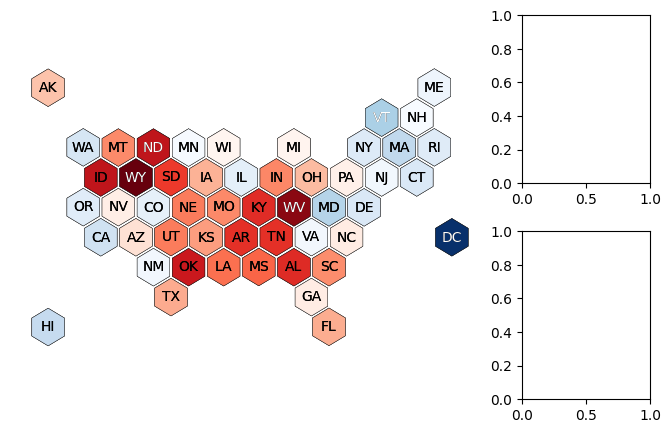

In [75]:
#Remove the previous plot
ax1.clear()

#Generate a choroplet map for the states where either Harris or Trump won
for candidate in (candidates := ['HARRIS', 'TRUMP']):
    df_merged[df_merged['WINNER'] == candidate].plot(ax=ax0, column='PERC_WINNER', edgecolor='black', cmap=cmaps[candidate], linewidth=0.3)

#Display state abbreviations

#Set thresholds for showing the state abbreviations black or white to maintain contrast
#black if < threshold, white otherwise
thresholds = dict()
for candidate in candidates:
    thresholds.update({candidate: df_merged[df_merged['WINNER'] == candidate]['PERC_WINNER'].quantile(q=0.90)})
    
for _, row in df_merged.iterrows():

    #Set text colour depending on the percentage of votes of the winner
    text_colour = 'black'
    if row['PERC_WINNER'] > thresholds[row['WINNER']]:
        text_colour = 'white'
        
    ax0.text(x=row['centroids'].x, y=row['centroids'].y, s=row['State_Abbr'], color=text_colour, ha='center', va='center')

#Suppress all axis decorations
ax0.set_axis_off()

display(fig)

### Add a legend

Let's add a legend to display the colour-to-magnitude mapping. We do this in two steps: first we manually generate the entries (rectangular patches and labels) that will appear in the legend, then create the legend. There will be one entry for each of the GDP levels defined in the `levels` variable.

In [76]:
#Define the levels that will appear in the legend  
levels = [55, 60, 65, 70, 75]
levels.reverse() #Swap the list to make the highest level appear at the top of the legend.

labels, patches = dict(), dict()

for candidate in candidates:

    df_candidate = df_merged[df_merged['WINNER'] == candidate]
    
    #Get the min and max GDP value for min-max normalisation (see below)
    bounds = (df_candidate['PERC_WINNER'].min(), df_candidate['PERC_WINNER'].max())

    #Load the colormap
    cmap = mpl.colormaps[cmaps[candidate]]

    labels[candidate], patches[candidate] = list(), list()

    for level in levels:

        #Apply min-max normalisation to retrieve the corresponding colour from the colormap
        norm_value = (level - bounds[0])/(bounds[1] - bounds[0])

        #Extract the corresponding colour from the colormap
        colour = cmap(norm_value)

        #Create a rectangular patch with the given colour
        patches[candidate].append(Patch(edgecolor='lightgrey', facecolor=colour, linewidth=0.3))

        #Create the corresponding label
        labels[candidate].append(f'{level} %')

#Get the electoral votes for each candidate

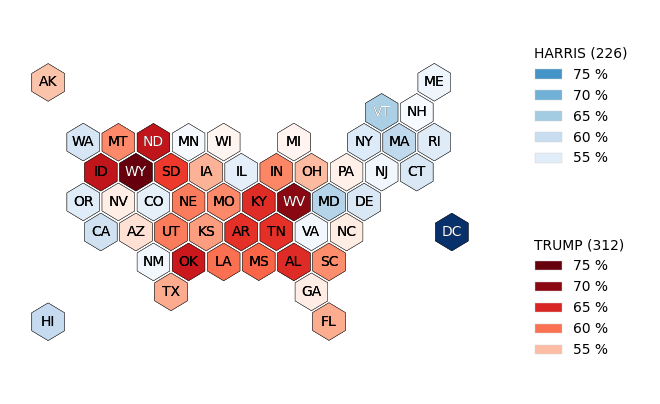

In [77]:
#Get the electoral votes for this candidate
el_votes_harris = df_merged[df_merged['WINNER'] == 'HARRIS']['ELECTORAL VOTES'].sum()
el_votes_trump = df_merged[df_merged['WINNER'] == 'TRUMP']['ELECTORAL VOTES'].sum()
    
leg1 = ax1.legend(handles=patches['HARRIS'], labels=labels['HARRIS'], loc='lower left', bbox_to_anchor=(0.0,0.0), title=f'HARRIS ({el_votes_harris})', frameon=False)
leg2 = ax2.legend(handles=patches['TRUMP'], labels=labels['HARRIS'], loc='upper left', bbox_to_anchor=(0.0,1.0), title=f'TRUMP ({el_votes_trump})', frameon=False)

for ax in [ax1, ax2]:
    ax.set_axis_off()

for leg in [leg1, leg2]:
    leg._legend_box.align = "left"

display(fig)

### Add title and subtitle

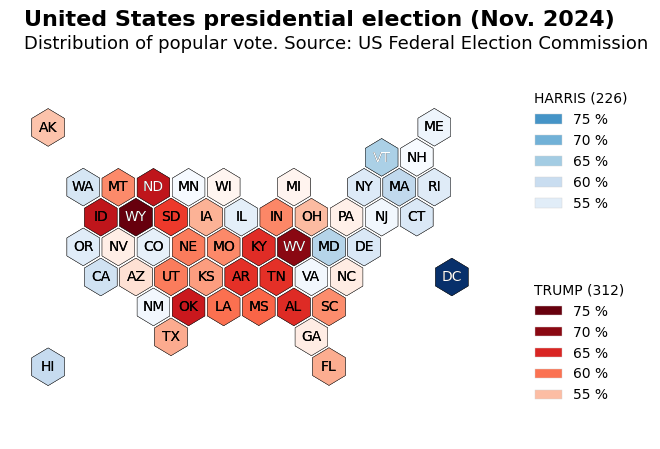

In [78]:
title = f'United States presidential election (Nov. 2024)'
subtitle = f'Distribution of popular vote. Source: US Federal Election Commission'
set_title_and_subtitle(fig=fig, title=title, subtitle=subtitle, alignment='left', h_offset=10)
display(fig)